# Notebook to test replacement of make_gtab_and_bmask with non_fsl replacements

## 1) Replace FSL BET with dipy median_ostu

## 2) Replace FSL ROI with direct python manipulation

## 3) Replace both

## 4) Test!

In [1]:
## import libraries

import ndmg
from ndmg import preproc as mgp

from ndmg import preproc
from ndmg import register
from ndmg import track
from ndmg import graph
from ndmg.utils import gen_utils
from ndmg.utils import reg_utils
from ndmg.utils import cloud_utils

from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table
from nilearn.image import mean_img

from unittest.mock import Mock
import nibabel as nib
import numpy as np 
import pytest
import os
import torch

import matplotlib.pyplot as plt
import dipy

Python location : /Users/wilsontang/anaconda3/bin/python
Python version : 3.6.8 |Anaconda, Inc.| (default, Dec 29 2018, 19:04:46) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
DiPy version : 1.0.0
Your fsl directory is located here: /usr/local/fsl
Your AFNI directory is located here: /Users/wilsontang/abin/afni

Beginning ndmg ...


### Replacement Functions for make_gtab_and_bmask


In [2]:
## functions
def replace_roi_make_gtab_and_bmask(fbval, fbvec, dwi_file, outdir):
    ### Replacement of roi with pure python
    """Takes bval and bvec files and produces a structure in dipy format while also using FSL commands
    
    Parameters
    ----------
    fbval : str
        b-value file
    fbvec : str
        b-vector file
    dwi_file : str
        dwi file being analyzed
    outdir : str
        output directory
    
    Returns
    -------
    GradientTable
        gradient table created from bval and bvec files
    str
        location of averaged b0 image file
    str
        location of b0 brain mask file
    """
    # Use B0's from the DWI to create a more stable DWI image for registration
    nodif_B0 = "{}/nodif_B0.nii.gz".format(outdir)
    nodif_B0_bet = "{}/nodif_B0_bet.nii.gz".format(outdir)
    nodif_B0_mask = "{}/nodif_B0_bet_mask.nii.gz".format(outdir)

    # loading bvecs/bvals
    print(fbval)
    print(fbvec)

    #temp adding mgu as import
    bvals, bvecs = read_bvals_bvecs(fbval, fbvec)

    # Creating the gradient table
    gtab = gradient_table(bvals, bvecs, atol=1.0)

    # Correct b0 threshold
    gtab.b0_threshold = min(bvals)

    # Get B0 indices
    B0s = np.where(gtab.bvals == gtab.b0_threshold)[0]
    print("%s%s" % ("B0's found at: ", B0s))

    # Show info
    print(gtab.info)

    # Extract and Combine all B0s collected
    print("Extracting B0's...")
    cmds = []
    B0s_bbr = []
    
    #load target image dwi_file
    dwi_file_loaded = nib.load(dwi_file)

    #Convert to numpy
    dwi_file_loaded_np = dwi_file_loaded.get_fdata()

    for B0 in B0s:
        print(B0)
        B0_bbr = "{}/{}_B0.nii.gz".format(outdir, str(B0))
        #save the B0th dimension, a 1 dimensional ROI at B0, the voxel corresponding to the B0th
        B0_dwi = dwi_file_loaded_np[:,:,:,B0]
        #convert back to nifti image using the affine of original image
        B0_nifti = nib.Nifti1Image(B0_dwi, dwi_file_loaded.affine)
        #save in path
        nib.save(B0_nifti, B0_bbr)
        #save for mean image later
        B0s_bbr.append(B0_bbr)
#old func
        # cmd = "fslroi " + dwi_file + " " + B0_bbr + " " + str(B0) + " 1"
        # cmds.append(cmd)


#     for cmd in cmds:
#         print(cmd)
#         os.system(cmd)

    # Get mean B0
    B0s_bbr_imgs = []
    for B0 in B0s_bbr:
        B0s_bbr_imgs.append(nib.load(B0))

    mean_B0 = mean_img(B0s_bbr_imgs)
    nib.save(mean_B0, nodif_B0)

#Get mean B0 brain mask
    cmd = "bet " + nodif_B0 + " " + nodif_B0_bet + " -m -f 0.2"
    os.system(cmd)

    return gtab, nodif_B0, nodif_B0_mask

def replace_bet_make_gtab_and_bmask(fbval, fbvec, dwi_file, outdir):
    """Takes bval and bvec files and produces a structure in dipy format while also using FSL commands
    
    Parameters
    ----------
    fbval : str
        b-value file
    fbvec : str
        b-vector file
    dwi_file : str
        dwi file being analyzed
    outdir : str
        output directory
    
    Returns
    -------
    GradientTable
        gradient table created from bval and bvec files
    str
        location of averaged b0 image file
    str
        location of b0 brain mask file
    """

    # Use B0's from the DWI to create a more stable DWI image for registration
    nodif_B0 = "{}/nodif_B0.nii.gz".format(outdir)
    nodif_B0_bet = "{}/nodif_B0_bet.nii.gz".format(outdir)
    nodif_B0_mask = "{}/nodif_B0_bet_mask.nii.gz".format(outdir)

    # loading bvecs/bvals
    print(fbval)
    print(fbvec)
    bvals, bvecs = read_bvals_bvecs(fbval, fbvec)

    # Creating the gradient table
    gtab = gradient_table(bvals, bvecs, atol=1.0)

    # Correct b0 threshold
    gtab.b0_threshold = min(bvals)

    # Get B0 indices
    B0s = np.where(gtab.bvals == gtab.b0_threshold)[0]
    print("%s%s" % ("B0's found at: ", B0s))

    # Show info
    print(gtab.info)

    # Extract and Combine all B0s collected
    print("Extracting B0's...")
    cmds = []
    B0s_bbr = []
    for B0 in B0s:
        print(B0)
        B0_bbr = "{}/{}_B0.nii.gz".format(outdir, str(B0))
        cmd = "fslroi " + dwi_file + " " + B0_bbr + " " + str(B0) + " 1"
        cmds.append(cmd)
        B0s_bbr.append(B0_bbr)

    for cmd in cmds:
        print(cmd)
        os.system(cmd)

    # Get mean B0
    B0s_bbr_imgs = []
    for B0 in B0s_bbr:
        B0s_bbr_imgs.append(nib.load(B0))

    mean_B0 = mean_img(B0s_bbr_imgs)
    nib.save(mean_B0, nodif_B0)
    
#old func
# #Get mean B0 brain mask
#     cmd = "bet " + nodif_B0 + " " + nodif_B0_bet + " -m -f 0.2"
#     os.system(cmd)
    
    ### using median_ostu 
    
    #extract data from file
    nodif_B0_data = nib.load(nodif_B0)
    nodif_B0_array = nodif_B0_data.get_fdata()
    
    #pass np array into dipy
    nodif_B0_dipy = dipy.segment.mask.median_otsu(nodif_B0_array)
    
    #extract bet and bet_mask
    nodif_B0_dipy_bet = nodif_B0_dipy[0]
    #encode True False as float 0,1
    nodif_B0_dipy_bet_mask = nodif_B0_dipy[1].astype(float)
    
    #apply affine to convert back into nifti image
    nodif_B0_dipy_bet_nifti = nib.Nifti1Image(nodif_B0_dipy_bet, nodif_B0_data.affine)
    nodif_B0_dipy_bet_mask_nifti = nib.Nifti1Image(nodif_B0_dipy_bet_mask, nodif_B0_data.affine)
    
    #store bet and bet_mask at designated locations
    nib.save(nodif_B0_dipy_bet_nifti, nodif_B0_bet)
    nib.save(nodif_B0_dipy_bet_mask_nifti, nodif_B0_mask)
    
    return gtab, nodif_B0, nodif_B0_mask

def replace_both_make_gtab_and_bmask(fbval, fbvec, dwi_file, outdir):
    """Takes bval and bvec files and produces a structure in dipy format while also using FSL commands
    
    Parameters
    ----------
    fbval : str
        b-value file
    fbvec : str
        b-vector file
    dwi_file : str
        dwi file being analyzed
    outdir : str
        output directory
    
    Returns
    -------
    GradientTable
        gradient table created from bval and bvec files
    str
        location of averaged b0 image file
    str
        location of b0 brain mask file
    """

    # Use B0's from the DWI to create a more stable DWI image for registration
    nodif_B0 = "{}/nodif_B0.nii.gz".format(outdir)
    nodif_B0_bet = "{}/nodif_B0_bet.nii.gz".format(outdir)
    nodif_B0_mask = "{}/nodif_B0_bet_mask.nii.gz".format(outdir)

    # loading bvecs/bvals
    print(fbval)
    print(fbvec)
    bvals, bvecs = read_bvals_bvecs(fbval, fbvec)

    # Creating the gradient table
    gtab = gradient_table(bvals, bvecs, atol=1.0)

    # Correct b0 threshold
    gtab.b0_threshold = min(bvals)

    # Get B0 indices
    B0s = np.where(gtab.bvals == gtab.b0_threshold)[0]
    print("%s%s" % ("B0's found at: ", B0s))

    # Show info
    print(gtab.info)

    # Extract and Combine all B0s collected
    print("Extracting B0's...")
    cmds = []
    B0s_bbr = []
        #load target image dwi_file
    dwi_file_loaded = nib.load(dwi_file)

    #Convert to numpy
    dwi_file_loaded_np = dwi_file_loaded.get_fdata()

    for B0 in B0s:
        print(B0)
        B0_bbr = "{}/{}_B0.nii.gz".format(outdir, str(B0))
        #save the B0th dimension, a 1 dimensional ROI at B0, the voxel corresponding to the B0th
        B0_dwi = dwi_file_loaded_np[:,:,:,B0]
        #convert back to nifti image using the affine of original image
        B0_nifti = nib.Nifti1Image(B0_dwi, dwi_file_loaded.affine)
        #save in path
        nib.save(B0_nifti, B0_bbr)
        #save for mean image later
        B0s_bbr.append(B0_bbr)
#     for B0 in B0s:
#         print(B0)
#         B0_bbr = "{}/{}_B0.nii.gz".format(outdir, str(B0))
#         cmd = "fslroi " + dwi_file + " " + B0_bbr + " " + str(B0) + " 1"
#         cmds.append(cmd)
    

#     for cmd in cmds:
#         print(cmd)
#         os.system(cmd)

    # Get mean B0
    B0s_bbr_imgs = []
    for B0 in B0s_bbr:
        B0s_bbr_imgs.append(nib.load(B0))

    mean_B0 = mean_img(B0s_bbr_imgs)
    nib.save(mean_B0, nodif_B0)
    
#old func
# #Get mean B0 brain mask
#     cmd = "bet " + nodif_B0 + " " + nodif_B0_bet + " -m -f 0.2"
#     os.system(cmd)
    
    ### using median_ostu 
    
    #extract data from file
    nodif_B0_data = nib.load(nodif_B0)
    nodif_B0_array = nodif_B0_data.get_fdata()
    
    #pass np array into dipy
    nodif_B0_dipy = dipy.segment.mask.median_otsu(nodif_B0_array)
    
    #extract bet and bet_mask
    nodif_B0_dipy_bet = nodif_B0_dipy[0]
    #encode True False as float 0,1
    nodif_B0_dipy_bet_mask = nodif_B0_dipy[1].astype(float)
    
    #apply affine to convert back into nifti image
    nodif_B0_dipy_bet_nifti = nib.Nifti1Image(nodif_B0_dipy_bet, nodif_B0_data.affine)
    nodif_B0_dipy_bet_mask_nifti = nib.Nifti1Image(nodif_B0_dipy_bet_mask, nodif_B0_data.affine)
    
    #store bet and bet_mask at designated locations
    nib.save(nodif_B0_dipy_bet_nifti, nodif_B0_bet)
    nib.save(nodif_B0_dipy_bet_mask_nifti, nodif_B0_mask)
    
    return gtab, nodif_B0, nodif_B0_mask



### Other Useful Functions for processing Results

In [3]:

def dice_score(A,B):
    """
    A: Baseline numpy array to be compared
    B: Alternative numpy arrray to be compared
    
    out: dice score
    """
    #smooth
    smooth = 1.0
    #convert to torch tensor and flatten
    A_flat = torch.from_numpy(A).contiguous().view(-1)
    B_flat = torch.from_numpy(B).contiguous().view(-1)
    
    #calc dice components
    intersection = (A_flat * B_flat).sum()
    A_sum = torch.sum(A_flat*A_flat)
    B_sum = torch.sum(B_flat*B_flat)
    
    #calc dice
    dice = (2. * intersection + smooth)/(A_sum + B_sum + smooth)
    
    return dice

def extract_data(outdir):
    nodif_B0 = "{}/nodif_B0.nii.gz".format(outdir)
    nodif_B0_bet = "{}/nodif_B0_bet.nii.gz".format(outdir)
    nodif_B0_mask = "{}/nodif_B0_bet_mask.nii.gz".format(outdir)
    
    nodif_B0_data = nib.load(nodif_B0).get_fdata()
    nodif_B0_bet_data = nib.load(nodif_B0_bet).get_fdata()
    nodif_B0_mask_data = nib.load(nodif_B0_mask).get_fdata()
    return [nodif_B0_data,nodif_B0_bet_data,nodif_B0_mask_data]

def graph_data_roi(og_data,roi_data):
    %matplotlib inline 
    plt.figure()

    f, ax = plt.subplots(1,2)

    ax[0].imshow(og_data[0][46]) 
    ax[0].set_title('Example Slice for FSL ROI')
    ax[1].imshow(roi_data[0][46])
    ax[1].set_title('Example Slice for PYTHON ROI')

    f.subplots_adjust(wspace = 2, hspace = 0.5)

    plt.show()

def graph_data_bet(og_data,bet_data):
    %matplotlib inline 
    plt.figure()

    f, ax = plt.subplots(2,2)

    ax[0,0].imshow(og_data[1][46]) 
    ax[0,0].set_title('Example Slice for FSL BET')
    ax[0,1].imshow(bet_data[1][46])
    ax[0,1].set_title('Example Slice for DIPY MEDIAN_OSTU')
    ax[1,0].imshow(og_data[2][46]) 
    ax[1,0].set_title('Example Mask_Slice for FSL BET')
    ax[1,1].imshow(bet_data[2][46])
    ax[1,1].set_title('Example Mask_Slice for DIPY MEDIAN_OSTU')

    f.subplots_adjust(wspace = 2, hspace = 0.5)

    plt.show()
    
def graph_data_both(og_data,both_data):
    %matplotlib inline 
    plt.figure()

    f, ax = plt.subplots(3,2)

    ax[0,0].imshow(og_data[0][46]) 
    ax[0,0].set_title('Example Slice for FSL ROI')
    ax[0,1].imshow(both_data[0][46])
    ax[0,1].set_title('Example Slice for Python ROI')
    
    ax[1,0].imshow(og_data[1][46])
    ax[1,0].set_title('Example Slice for FSL BET')
    ax[1,1].imshow(both_data[1][46])
    ax[1,1].set_title('Example Slice for DIPY MEDIAN_OSTU')
    
    ax[2,0].imshow(og_data[2][46])     
    ax[2,0].set_title('Example Mask_Slice for FSL BET')
    ax[2,1].imshow(both_data[2][46])
    ax[2,1].set_title('Example Mask_Slice for DIPY MEDIAN_OSTU')

    f.subplots_adjust(wspace = 2, hspace = 1)

    plt.show()

### Test Dice Score

In [4]:
#test dice 
nodif_B0 = '/Users/wilsontang/Desktop/ndmg_outputs/sub_0025864_/dwi/preproc/nodif_B0.nii.gz'
#test what it outputs. 
nodif_B0_data = nib.load(nodif_B0)
nodif_B0_array = nodif_B0_data.get_fdata()

nodif_zeros = np.zeros(nodif_B0_array.shape)
print(nodif_zeros.shape)

print(dice_score(nodif_B0_array,nodif_B0_array))
print(dice_score(nodif_B0_array,nodif_zeros))

(141, 141, 68)
tensor(1., dtype=torch.float64)
tensor(1.3165e-11, dtype=torch.float64)


### Run Tests for Replacement Functions: Calculate Dice and Graph Sample Outputs

In [5]:
### define data directories
base_path = '/Users/wilsontang/Desktop/ndmg_outputs'
file_folder = '/dwi/preproc/'

# sub_0025841_ses_1 = base_path + 'sub_0025841_ses_1' + file_folder
# sub_0025841_ses_2 = base_path + 'sub_0025841_ses_2' + file_folder
# sub_0025842_ses_1 = base_path + 'sub_0025842_ses_1' + file_folder
# sub_0025842_ses_2 = base_path + 'sub_0025842_ses_2' + file_folder
# sub_0025843_ses_1 = base_path + 'sub_0025843_ses_1' + file_folder
# sub_0025843_ses_2 = base_path + 'sub_0025843_ses_2' + file_folder
# sub_0025844_ses_1 = base_path + 'sub_0025844_ses_1' + file_folder
# sub_0025844_ses_2 = base_path + 'sub_0025844_ses_2' + file_folder
# sub_0025845_ses_1 = base_path + 'sub_0025845_ses_1' + file_folder
# sub_0025845_ses_2 = base_path + 'sub_0025841_ses_2' + file_folder

#BNU1 enabled for now
sub_0025864_ = base_path + '/sub_0025864_' + file_folder

#base
out_dir_base = '/Users/wilsontang/Desktop/make_gtab_and_bmask_temp/'

data_dir = [('sub_0025864_',sub_0025864_)]
out_dir = [out_dir_base + 'sub_0025864_']
print(data_dir)
print(out_dir)

[('sub_0025864_', '/Users/wilsontang/Desktop/ndmg_outputs/sub_0025864_/dwi/preproc/')]
['/Users/wilsontang/Desktop/make_gtab_and_bmask_temp/sub_0025864_']


/Users/wilsontang/Desktop/ndmg_outputs/sub_0025864_/dwi/preproc//bval.bval
/Users/wilsontang/Desktop/ndmg_outputs/sub_0025864_/dwi/preproc//bvec.bvec
B0's found at: [0]
B-values shape (31,)
         min 0.000000 
         max 1000.000000 
B-vectors shape (31, 3)
         min -0.978756 
         max 0.979329 
None
Extracting B0's...
0
fslroi /Users/wilsontang/Desktop/ndmg_outputs/sub_0025864_/dwi/preproc//eddy_corrected_data_reor_RAS_res.nii.gz /Users/wilsontang/Desktop/ndmg_outputs/sub_0025864_/dwi/preproc//0_B0.nii.gz 0 1
/Users/wilsontang/Desktop/ndmg_outputs/sub_0025864_/dwi/preproc//bval.bval
/Users/wilsontang/Desktop/ndmg_outputs/sub_0025864_/dwi/preproc//bvec.bvec
B0's found at: [0]
B-values shape (31,)
         min 0.000000 
         max 1000.000000 
B-vectors shape (31, 3)
         min -0.978756 
         max 0.979329 
None
Extracting B0's...
0
/Users/wilsontang/Desktop/ndmg_outputs/sub_0025864_/dwi/preproc//bval.bval
/Users/wilsontang/Desktop/ndmg_outputs/sub_0025864_/dwi/prep

<Figure size 432x288 with 0 Axes>

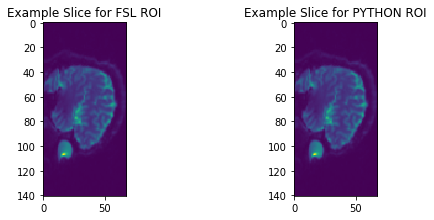

Original BET vs. Median OSTU: Dice Score per File and Sample Visualizations
[1] nodif_B0_bet: 0.9497404057263638 [2] nodif_B0_bmask: 0.8910177947162953


<Figure size 432x288 with 0 Axes>

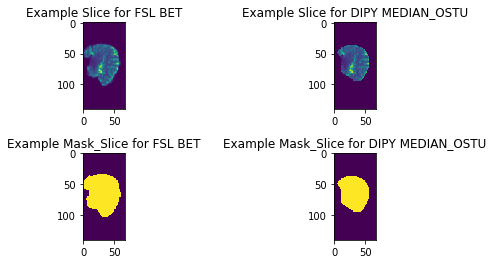

Original ROI,BET vs. ROI Replacement, Median OSTU: Dice Score per File and Sample Visualizations
[1] nodif_B0: 1.0 [2] nodif_B0_bet: 0.9497404057263638 [3] nodif_B0_bmask: 0.8910177947162953


<Figure size 432x288 with 0 Axes>

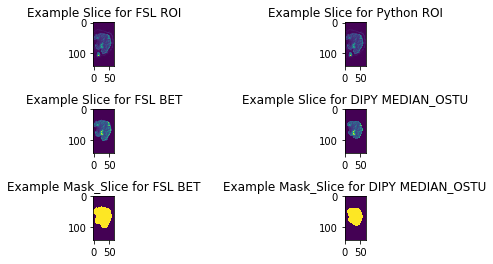

In [6]:

#run across multiple file directories, 
for i in range(len(data_dir)):
    #define correct input data path
    in_dir = data_dir[i][1]
    fbval_in_path = "{}/bval.bval".format(in_dir)
    fbvec_in_path = "{}/bvec.bvec".format(in_dir)
    dwi_prep_in_path = "{}/eddy_corrected_data_reor_RAS_res.nii.gz".format(in_dir)
    
#     #create 4 outdirs to store our experiment results
#     outdir = [out_dir[i] + '/og', out_dir[i] + '/roi', out_dir[i] + '/bet', out_dir[i] + '/both']
    
    #run each version, locally store variables, rewrite the in_dir files corresponding to outputs, inputs to each will remain the same
    #original
    [gtab_og, nodif_B0_out_temp_path_og, nodif_B0_mask_out_temp_path_og] = gen_utils.make_gtab_and_bmask(fbval_in_path, fbvec_in_path, dwi_prep_in_path, in_dir)
    og_data = extract_data(in_dir)
    #replace roi
    [gtab_roi, nodif_B0_out_temp_path_roi, nodif_B0_mask_out_temp_path_roi] = replace_roi_make_gtab_and_bmask(fbval_in_path, fbvec_in_path, dwi_prep_in_path, in_dir)
    roi_data = extract_data(in_dir)
    #replace bet
    [gtab_bet, nodif_B0_out_temp_path_bet, nodif_B0_mask_out_temp_path_bet] = replace_bet_make_gtab_and_bmask(fbval_in_path, fbvec_in_path, dwi_prep_in_path, in_dir)
    bet_data = extract_data(in_dir)
    #replace both
    [gtab_both, nodif_B0_out_temp_path_both, nodif_B0_mask_out_temp_path_both] = replace_both_make_gtab_and_bmask(fbval_in_path, fbvec_in_path, dwi_prep_in_path, in_dir)
    both_data = extract_data(in_dir)
    
    #alternatively, make 4 separate folders with the data, then pass each in so the results are always saved
    
    #compare with dice: nodif_B0, nodif_B0_bet, nodif_B0_bet_mask
    print('Dice Comparisons for: ' + data_dir[i][0])
    print('Original ROI vs. ROI Replacement: Dice Score per File and Sample Visualizations')
    print('[1] nodif_B0: '+ str( dice_score(og_data[0],roi_data[0]).item()) ) 
    graph_data_roi(og_data,roi_data)
    print('Original BET vs. Median OSTU: Dice Score per File and Sample Visualizations')
    print('[1] nodif_B0_bet: ' + str(dice_score(og_data[1],bet_data[1]).item()) + ' [2] nodif_B0_bmask: ' + str(dice_score(og_data[2],bet_data[2]).item()) )
    graph_data_bet(og_data,bet_data)
    print('Original ROI,BET vs. ROI Replacement, Median OSTU: Dice Score per File and Sample Visualizations')
    print('[1] nodif_B0: '+ str(dice_score(og_data[0],both_data[0]).item()) + ' [2] nodif_B0_bet: ' + str(dice_score(og_data[1],both_data[1]).item()) + ' [3] nodif_B0_bmask: ' + str(dice_score(og_data[2],both_data[2]).item()))
    graph_data_both(og_data,both_data)

Original ROI,BET vs. ROI Replacement, Median OSTU: Dice Score per File and Sample Visualizations
[1] nodif_B0: 1.0 [2] nodif_B0_bet: 0.9497404057263638 [3] nodif_B0_bmask: 0.8910177947162953


<Figure size 432x288 with 0 Axes>

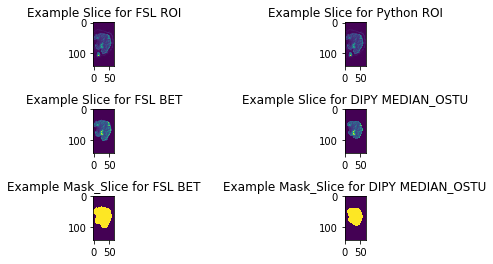

In [7]:

print('Original ROI,BET vs. ROI Replacement, Median OSTU: Dice Score per File and Sample Visualizations')
print('[1] nodif_B0: '+ str(dice_score(og_data[0],both_data[0]).item()) + ' [2] nodif_B0_bet: ' + str(dice_score(og_data[1],both_data[1]).item()) + ' [3] nodif_B0_bmask: ' + str(dice_score(og_data[2],both_data[2]).item()))
graph_data_both(og_data,both_data)